In [1]:
import ROOT
from ipywidgets import interact, IntSlider, IntText

f = ROOT.TFile('fitTreeOut.root')
if not ROOT.gROOT.FindObject('canv'):
    c = ROOT.TCanvas('canv', 'canv', 1400, 800)
if not ROOT.gROOT.FindObject('splitcanv'):
    split_c = ROOT.TCanvas('splitcanv', 'splitcanv', 1800, 1200)
    split_c.Divide(9, 6, 0, 0)
module_label = 'Calo23Fits'
splines = [f.Get('{0}/splines/spline{1}'.format(module_label, i)) for i in xrange(54)]
t = f.Get('{}/fits/fitTree'.format(module_label))
nEntries = t.BuildIndex('fillNum', 'islandNum*(xtalNum == 0) - 1*(xtalNum!=0)')

Welcome to ROOTaaS 6.06/00


In [2]:
# define plotting functions

def plot_fit(entry_num, canvas, single=True, grid_index=0):
    t.GetEntry(entry_num)
    # build graph
    sample_g = ROOT.TGraph(0)
    sample_g.SetName('g{}'.format(grid_index))
    if single:
        sample_g.SetTitle('run {0}, fill {2}, island {3}, xtal {1}; sample num; adc counts'.
                          format(t.runNum, t.xtalNum, t.fillNum, t.islandNum))
    sample_g.SetMarkerStyle(20)
    sample_g.SetMarkerSize(1.5)
    sample_g.SetMarkerColor(ROOT.kBlack)
    for i, samp in enumerate(t.trace):
        sample_g.SetPoint(i, i + t.firstSampleNum, samp)
    
    # build fit function
    spline = splines[t.xtalNum]
    # need to copy parameters or closure doesn't work as intended
    energies = [e for e in t.energies]
    times = [float(t0) for t0 in t.times]
    ped = float(t.pedestal)
    def fit_func(x):
        val = ped
        for (energy, t0) in zip(energies, times):
            if spline.GetXmin() < (x[0]-t0) < spline.GetXmax():
                val += -1*energy*spline.Eval(x[0]-t0)
        return val
    
    # draw graph and fit 
    sample_g.Draw("ap")
    x_min, x_max = (t.firstSampleNum, t.firstSampleNum + sample_g.GetN())
    y_min, y_max = (sample_g.GetYaxis().GetXmin(), sample_g.GetYaxis().GetXmax())
    sample_g.GetXaxis().SetLimits(x_min, x_max)
    if not single:
        # scale based on ADC range for grid plot
        sample_g.GetYaxis().SetRangeUser(-2047, 2048)
    fitTF1 = ROOT.TF1('fitfunc{}'.format(grid_index), fit_func, t.firstSampleNum, 
                      t.firstSampleNum + len(t.trace), 0)
    fitTF1.SetNpx(1000)
    fitTF1.SetLineColor(ROOT.kMagenta + 2)
    # don't draw failed fits
    if t.chi2 > 0:
        fitTF1.Draw("p same")
    
    if not single:
        sample_g.GetXaxis().SetLabelOffset(999)
        sample_g.GetYaxis().SetLabelOffset(999)
        return (sample_g, fitTF1)

    # make text box
    x_range, y_range = (x_max - x_min, y_max - y_min)
    txtbox = ROOT.TPaveText(x_min + 0.5*x_range, y_min + 0.6*y_range, 
                            x_min + 0.9*x_range, y_min + 0.1*y_range)
    txtbox.SetFillColor(ROOT.kWhite)
    txtbox.SetLineColor(ROOT.kWhite)
    txtbox.SetShadowColor(ROOT.kWhite)
    for (i, (energy, t0)) in enumerate(zip(t.energies, t.times)):
        txtbox.AddText('t_{{{0}}}: {1:0.3f}'.format(i, t0))
        txtbox.AddText('E_{{{0}}}: {1:0.1f}'.format(i, energy))
    txtbox.AddText('pedestal: {:0.1f}'.format(t.pedestal))
    txtbox.AddText('#chi^{{2}}: {:0.1f}'.format(t.chi2))
    txtbox.Draw()
    canvas.Draw()

def plot_one_with_index(fill_num, island_num, xtal_num):
    ROOT.gStyle.SetOptTitle(1)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1L:
        c.cd()
        plot_fit(entry_num + xtal_num, c)
    else:
        print('entry not found in index')

def plot_grid_with_index(fill_num, island_num):
    ROOT.gStyle.SetOptTitle(0)
    entry_num = t.GetEntryNumberWithIndex(fill_num, island_num)
    if entry_num != -1L:
        # have to make sure objects are not garbage collected
        objects = []
        for xtal_num in xrange(54):
            split_c.cd(54 - xtal_num)
            objects.append(plot_fit(entry_num, split_c, single=False, grid_index=xtal_num))
            entry_num += 1
        split_c.Draw()
    else:
        print('entry not found in index')

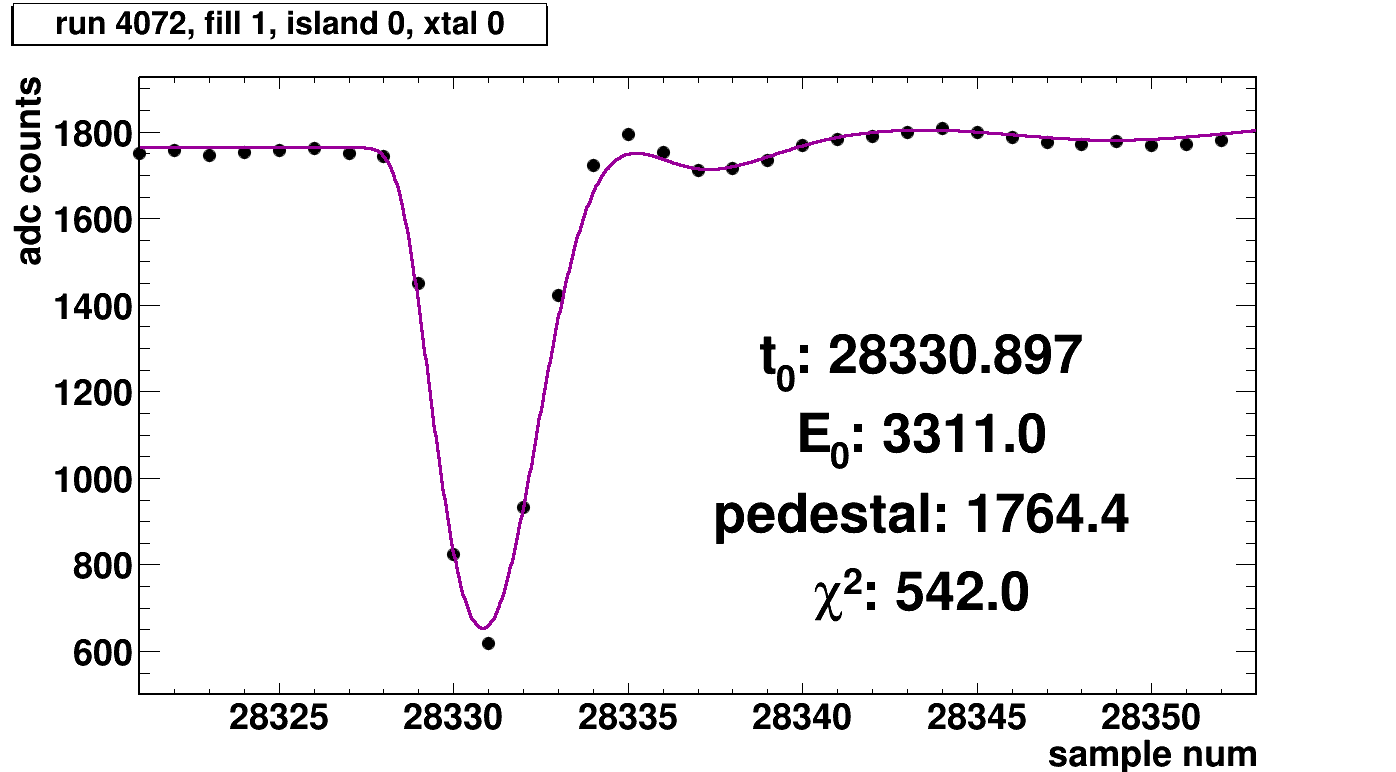

In [3]:
dummy = interact(plot_one_with_index, fill_num=IntSlider(min=1, max=100, step=1, value=0), 
                 island_num=IntSlider(min=0, max=100, step=1, value=0), 
                 xtal_num=IntSlider(min=0, max=53, step=1, value=0))

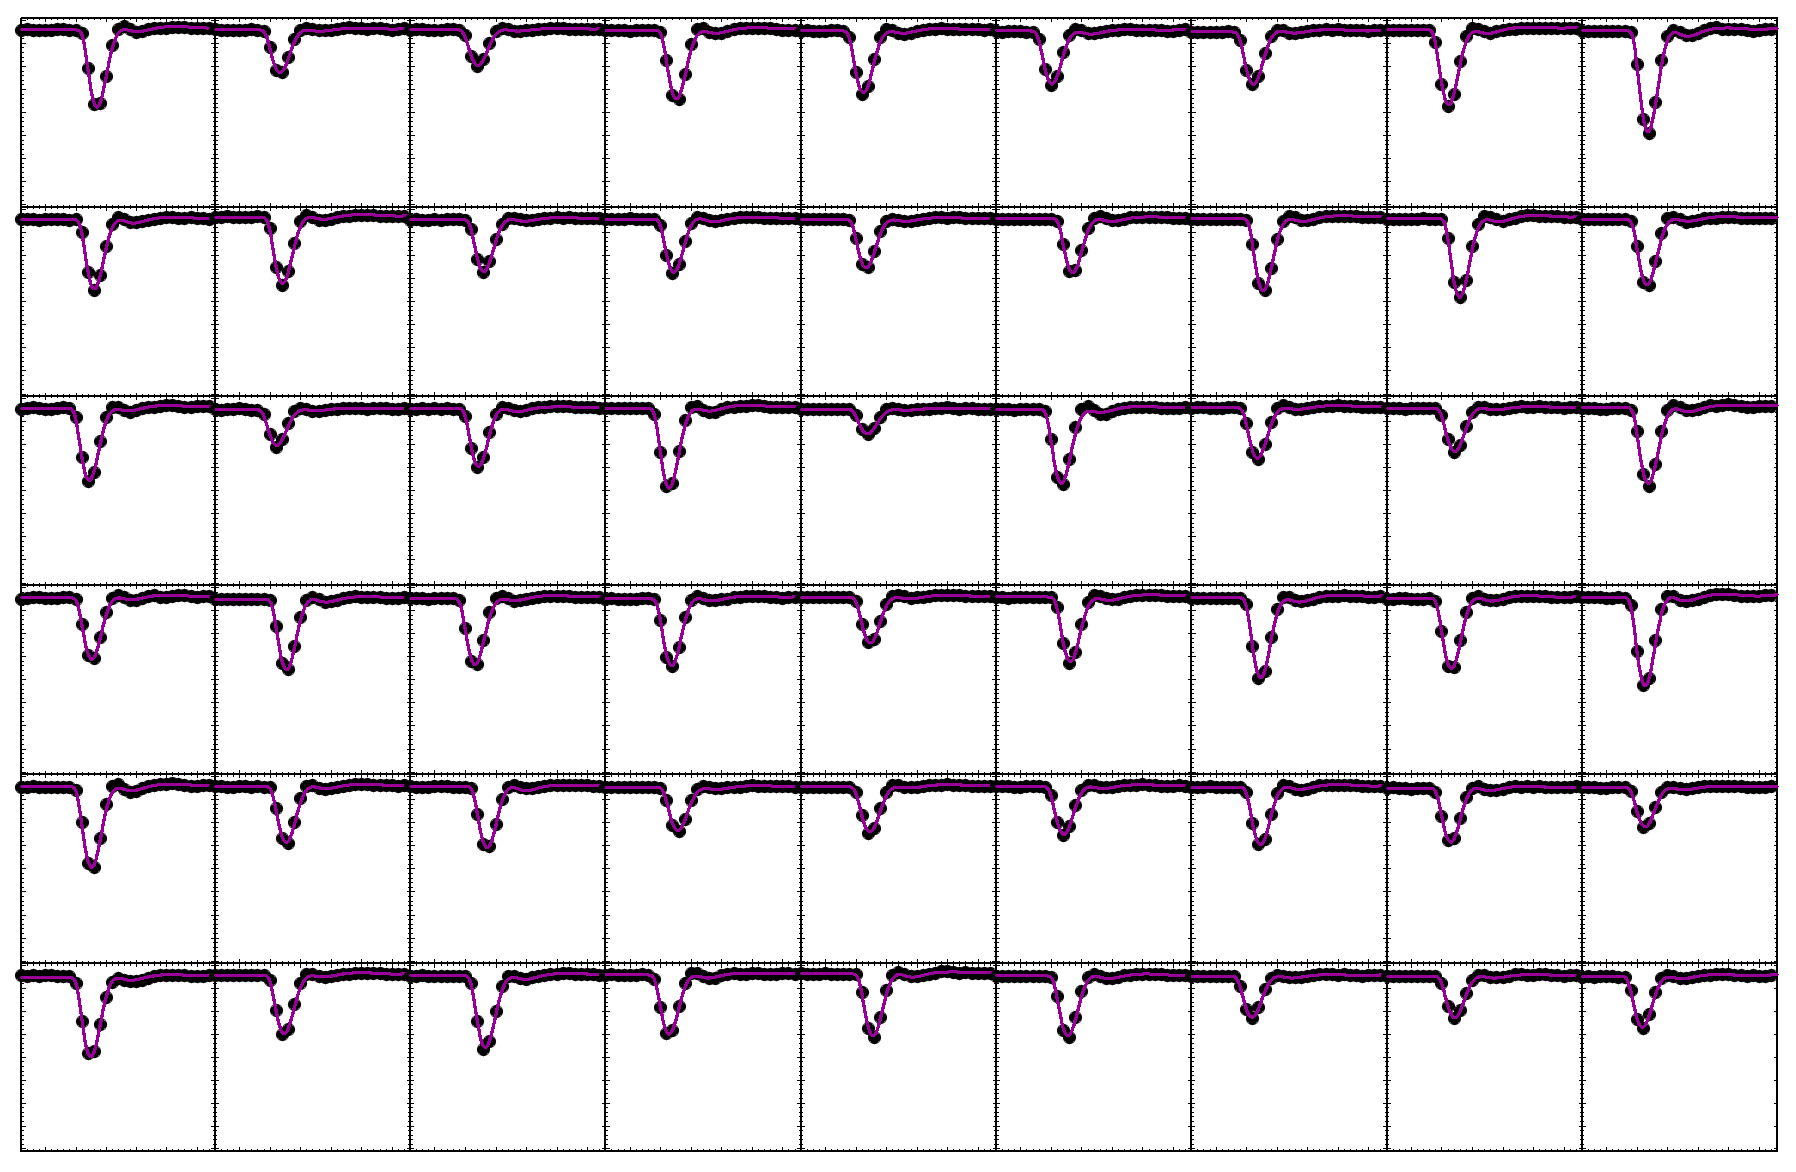

In [4]:
dummy = interact(plot_grid_with_index, fill_num=IntText(min=1, value=1), 
                 island_num=IntText(min=0, value=0))